JAGS: Just Another Gibb Sampler

Adapted from https://users.soe.ucsc.edu/~draper/eBay-Google-2013-parallel-rjags-example.txt
Some helpers and example usage of rjags in parallel mode in R. The output from the foreach functions below give an mcmc object that can be manipulated with the coda package, which is automatically loaded with rjags.

The base code is from: http://andrewgelman.com/2011/07/parallel-jags-rngs/ with some updates and a nice combine function. 

This notebook version comes with instruction on installling the required packages in a non-root environment on Clemson University, and some modifications on the initial source code to deal with the setting of non-variable node. 

To set up JAGS, download the software, and install it into a predefined directory, in this case */home/lngo/software*:
<code>
module load gcc/4.8.1
tar xzf JAGS-4.2.0.tar.gz
cd JAGS-4.2.0
./configure --prefix=/home/lngo/software
make
make install
</code>

Prior to the launching of the Jupyter server, the Linux shell environment needs to load the environment variables PKG_CONFIG_PATH, which points to */home/lngo/software/JAGS-4.2.0/lib/pkgconfig*, and LD_LIBRARY_PATH, which contains */home/lngo/software/JAGS-4.2.0/lib/*. 

This can be accomplished by creating a file called R_jupyter.sh that contains the following lines:
<code>
#!/bin/bash
export PKG_CONFIG_PATH="/home/lngo/software/JAG-4.2.0/lib/pkgconfig"
export LD_LIBRARY_PATH="$LD_LIBRARY_PATH:/home/lngo/software/JAG-4.2.0/lib"
</code>

Users then can insert a single line into *.bashrc* to enable this environment:
<code>
source R_jupyter.sh
</code>

In [1]:
# Second, install the following packages into a non-root directory, in this case /home/lngo/R_libs
#  doParallel
#  rjags
#  random

install.packages(c("rjags","doParallel","random"), 
                 lib="/home/lngo/R_libs", 
                 repos='http://cran.us.r-project.org',
                 verbose=TRUE)

system (cmd0): /software/anaconda3/2.5.0/envs/R/lib/R/bin/R CMD INSTALL
foundpkgs: rjags, doParallel, random, /local_scratch/pbs.4623091.pbs02/Rtmpwt3cEi/downloaded_packages/rjags_4-6.tar.gz, /local_scratch/pbs.4623091.pbs02/Rtmpwt3cEi/downloaded_packages/doParallel_1.0.10.tar.gz, /local_scratch/pbs.4623091.pbs02/Rtmpwt3cEi/downloaded_packages/random_0.2.5.tar.gz
files: /local_scratch/pbs.4623091.pbs02/Rtmpwt3cEi/downloaded_packages/rjags_4-6.tar.gz, 
	/local_scratch/pbs.4623091.pbs02/Rtmpwt3cEi/downloaded_packages/doParallel_1.0.10.tar.gz, 
	/local_scratch/pbs.4623091.pbs02/Rtmpwt3cEi/downloaded_packages/random_0.2.5.tar.gz
1): succeeded '/software/anaconda3/2.5.0/envs/R/lib/R/bin/R CMD INSTALL -l '/home/lngo/R_libs' /local_scratch/pbs.4623091.pbs02/Rtmpwt3cEi/downloaded_packages/rjags_4-6.tar.gz'
2): succeeded '/software/anaconda3/2.5.0/envs/R/lib/R/bin/R CMD INSTALL -l '/home/lngo/R_libs' /local_scratch/pbs.4623091.pbs02/Rtmpwt3cEi/downloaded_packages/doParallel_1.0.10.tar.gz'
3): s

In [2]:
# Third, load the installed library. Note that because these libraries are not installed into a default location, the 
# lib parameter within library also needs to be specified

library(doParallel,lib="/home/lngo/R_libs")
library(coda,lib="/home/lngo/R_libs")
library(rjags,lib="/home/lngo/R_libs")
library(random,lib="/home/lngo/R_libs")

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


In [3]:
# Function to generate the initial values and random seeds for each model. tau = 0.05 in old version
nb10.inits.1 <- function( ) {
  return( list( mu = 404.59, nu = 5.0, y.new = 400.0, 
    .RNG.name = "lecuyer::RngStream", 
    .RNG.seed = randomNumbers( n = 1, min = 1, max = 1e+06, col = 1 ) ) )
}
# Data to use
nb10.data.1 <- list( 
  y = c( 409., 400., 406., 399., 402., 406., 401., 403., 401., 403.,
         398., 403., 407., 402., 401., 399., 400., 401., 405., 402., 
         408., 399., 399., 402., 399., 397., 407., 401., 399., 401., 
         403., 400., 410., 401., 407., 423., 406., 406., 402., 405., 
         405., 409., 399., 402., 407., 406., 413., 409., 404., 402., 
         404., 406., 407., 405., 411., 410., 410., 410., 401., 402., 
         404., 405., 392., 407., 406., 404., 403., 408., 404., 407., 
         412., 406., 409., 400., 408., 404., 401., 404., 408., 406., 
         408., 406., 401., 412., 393., 437., 418., 415., 404., 401., 
         401., 407., 412., 375., 409., 406., 398., 406., 403., 404.), 
  n = 100 )

# Helper function to combine multiple mcmc lists into a single one. 
mcmc.combine <- function( ... ) {
  return( as.mcmc.list( sapply( list( ... ), mcmc ) ) )
}

In [4]:
# Single-threaded run
iters <- 100000
time.1 <- system.time(
  jags.singlesample <- foreach( i = 1:1, .combine = "mcmc.combine", 
    .multicombine = TRUE) %do% {
    load.module("lecuyer")
    model.jags <- jags.model( data = nb10.data.1, file = "nb10-model-1.txt", 
      inits = nb10.inits.1 )
    result <- coda.samples( model.jags, variable.names = c("mu","sigma","nu", "y.new"), n.iter = iters )
    return( result )
  }
)

module lecuyer loaded


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 3
   Total graph size: 112



Warning message:
In jags.model(data = nb10.data.1, file = "nb10-model-1.txt", inits = nb10.inits.1): Unused initial value for "nu" in chain 1

Initializing model



Warning message:
In jags.samples(model, variable.names, n.iter, thin, type = "trace", : Failed to set trace monitor for nu
Variable nu not found


In [5]:
registerDoParallel(2) 
iters <- 50000

time.2 <- system.time(
  jags.parsamples.2 <- foreach( i = 1:getDoParWorkers( ), .inorder = FALSE, 
    .packages = c( 'rjags', 'random' ), .combine = "mcmc.combine", 
    .multicombine = TRUE ) %dopar% {
      load.module( "lecuyer" )
      model.file <- "nb10-model-1.txt"
      model.jags <- jags.model(data = nb10.data.1,file = model.file,inits = nb10.inits.1)
      result <- coda.samples( model.jags, variable.names = c("mu","sigma","nu","y.new"),n.iter = iters )
    return(result)
  }
) 

In [6]:
registerDoParallel(4) 
iters <- 25000
time.4 <- system.time(
  jags.parsamples.4 <- foreach( i = 1:getDoParWorkers( ), .inorder = FALSE, 
    .packages = c( 'rjags', 'random' ), .combine = "mcmc.combine", 
    .multicombine = TRUE ) %dopar% {
      load.module( "lecuyer" )
      model.file <- "nb10-model-1.txt"
      model.jags <- jags.model(data = nb10.data.1,file = model.file,inits = nb10.inits.1)
      result <- coda.samples( model.jags, variable.names = c("mu","sigma","nu","y.new"),n.iter = iters )
    return(result)
  }
)

In [7]:
registerDoParallel(8) 
iters <- 12500
time.8 <- system.time(
  jags.parsamples.8 <- foreach( i = 1:getDoParWorkers( ), .inorder = FALSE, 
    .packages = c( 'rjags', 'random' ), .combine = "mcmc.combine", 
    .multicombine = TRUE ) %dopar% {
      load.module( "lecuyer" )
      model.file <- "nb10-model-1.txt"
      model.jags <- jags.model(data = nb10.data.1,file = model.file,inits = nb10.inits.1)
      result <- coda.samples( model.jags, variable.names = c("mu","sigma","nu","y.new"),n.iter = iters )
    return(result)
  }
)

In [8]:
registerDoParallel(16) 
iters <- 6250
time.16 <- system.time(
  jags.parsamples.8 <- foreach( i = 1:getDoParWorkers( ), .inorder = FALSE, 
    .packages = c( 'rjags', 'random' ), .combine = "mcmc.combine", 
    .multicombine = TRUE ) %dopar% {
      load.module( "lecuyer" )
      model.file <- "nb10-model-1.txt"
      model.jags <- jags.model(data = nb10.data.1,file = model.file,inits = nb10.inits.1)
      result <- coda.samples( model.jags, variable.names = c("mu","sigma","nu","y.new"),n.iter = iters )
    return(result)
  }
)

In [9]:
registerDoParallel(32) 
iters <- 3125
time.32 <- system.time(
  jags.parsamples.8 <- foreach( i = 1:getDoParWorkers( ), .inorder = FALSE, 
    .packages = c( 'rjags', 'random' ), .combine = "mcmc.combine", 
    .multicombine = TRUE ) %dopar% {
      load.module( "lecuyer" )
      model.file <- "nb10-model-1.txt"
      model.jags <- jags.model(data = nb10.data.1,file = model.file,inits = nb10.inits.1)
      result <- coda.samples( model.jags, variable.names = c("mu","sigma","nu","y.new"),n.iter = iters )
    return(result)
  }
)

In [10]:
print (time.32)
print (time.16)
print (time.8)
print (time.4)
print (time.2)
print (time.1)

   user  system elapsed 
  9.082   0.474   1.449 
   user  system elapsed 
  7.515   0.250   1.394 
   user  system elapsed 
  6.843   0.133   1.607 
   user  system elapsed 
  6.798   0.091   2.071 
   user  system elapsed 
  2.541   0.027   3.308 
   user  system elapsed 
  4.970   0.023   7.003 


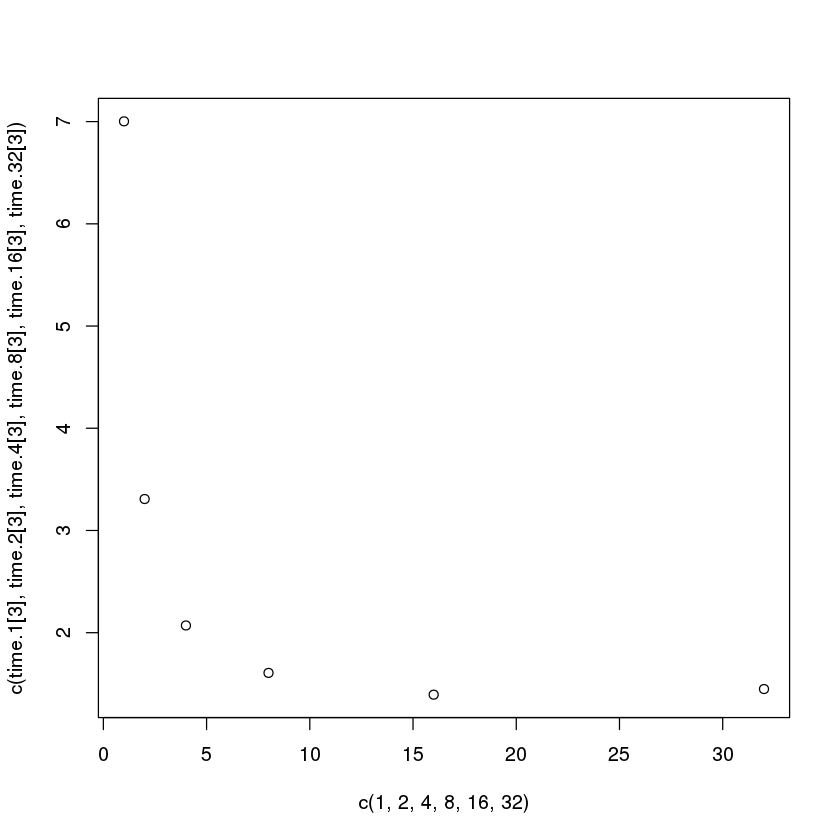

In [11]:
plot(x = c(1,2,4,8,16,32), y=c(time.1[3], time.2[3], time.4[3], time.8[3], time.16[3], time.32[3]))

In [12]:
summary( jags.parsamples.8 )
summary( jags.parsamples.4 )
# Iterations = 1001:26000
# Thinning interval = 1 
# Number of chains = 4 
# Sample size per chain = 25000 

# 1. Empirical mean and standard deviation for each variable,
#    plus standard error of the mean:

#          Mean     SD Naive SE Time-series SE
# mu    404.295 0.4719 0.001492       0.001920
# nu      3.637 1.1875 0.003755       0.007821
# sigma   3.863 0.4375 0.001384       0.002462
# y.new 404.295 6.8578 0.021686       0.021686

# 2. Quantiles for each variable:

#          2.5%     25%     50%     75%   97.5%
# mu    403.374 403.978 404.296 404.611 405.224
# nu      2.139   2.804   3.387   4.177   6.638
# sigma   3.078   3.558   3.840   4.141   4.793
# y.new 392.631 401.356 404.282 407.200 416.000

summary( jags.singlesample )
# Iterations = 1001:101000
# Thinning interval = 1 
# Number of chains = 1 
# Sample size per chain = 1e+05 

# 1. Empirical mean and standard deviation for each variable,
#    plus standard error of the mean:

#          Mean     SD Naive SE Time-series SE
# mu    404.299 0.4731 0.001496       0.001917
# nu      3.631 1.1653 0.003685       0.007388
# sigma   3.864 0.4348 0.001375       0.002436
# y.new 404.315 6.6972 0.021178       0.021178

# 2. Quantiles for each variable:

#          2.5%     25%     50%     75%   97.5%
# mu    403.379 403.980 404.295 404.615 405.236
# nu      2.142   2.807   3.387   4.165   6.567
# sigma   3.081   3.560   3.841   4.142   4.782
# y.new 392.684 401.398 404.307 407.196 416.070


Iterations = 1001:4125
Thinning interval = 1 
Number of chains = 32 
Sample size per chain = 3125 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
mu    404.590 0.6566 0.002076       0.002084
sigma   6.549 0.4754 0.001503       0.002009
y.new 404.563 6.5635 0.020756       0.020744

2. Quantiles for each variable:

         2.5%     25%     50%     75%   97.5%
mu    403.297 404.148 404.593 405.028 405.872
sigma   5.702   6.215   6.521   6.852   7.556
y.new 391.679 400.164 404.577 408.999 417.461



Iterations = 1001:26000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 25000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
mu    404.592 0.6562 0.002075       0.002085
sigma   6.553 0.4763 0.001506       0.002006
y.new 404.610 6.5981 0.020865       0.020865

2. Quantiles for each variable:

         2.5%    25%     50%     75%   97.5%
mu    403.308 404.15 404.592 405.027 405.885
sigma   5.698   6.22   6.525   6.854   7.572
y.new 391.643 400.20 404.617 409.030 417.550



Iterations = 1001:101000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD Naive SE Time-series SE
mu    404.588 0.6576 0.002079       0.002079
sigma   6.549 0.4739 0.001499       0.001946
y.new 404.619 6.6155 0.020920       0.020920

2. Quantiles for each variable:

         2.5%     25%     50%     75%   97.5%
mu    403.302 404.146 404.587 405.031 405.875
sigma   5.701   6.218   6.519   6.851   7.551
y.new 391.655 400.149 404.615 409.054 417.618


In [13]:
#plot( jags.parsamples )
#xyplot( jags.parsamples[ , c( "mu", "nu" ) ] )
#autocorr.plot( jags.parsamples )